# **Sentiment Classification with Convolutional Neural Networks**

### **[Part 1] Google Drive Mount**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive




---



### **[Part 2] Install Library**

In [4]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import codecs

from tqdm import tqdm
plt.style.use('bmh')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




---



### **[Part 3] Load Dataset**

In [0]:
train = pd.read_excel('/content/drive/My Drive/Tugas_Akhir/dataset/train.xlsx', index_col=0)
test  = pd.read_excel('/content/drive/My Drive/Tugas_Akhir/dataset/test_label.xlsx', index_col=0)

In [0]:
X_train = train['text'].tolist()
y_train = train['label'].tolist()



---



### **[Part 4] Load FastText Model**

In [0]:
print('\n=============================')
print(' > Loading Word Embeddings > ')
print('=============================')

embeddings_index = {}

f = codecs.open('/content/drive/My Drive/Tugas_Akhir/model/ft_model.vec', encoding='utf-8')

for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('\n\nNumber of Word Vectors : ', len(embeddings_index))
print('Number of Train Data   : ', train.shape[0])
print('Number of Test Data    : ', test.shape[0])



 > Loading Word Embeddings > 


201428it [00:11, 18284.50it/s]



Number of Word Vectors :  201428
Number of Train Data   :  2900
Number of Test Data    :  682




---



### **[Part 5] Comment Length Visualization**

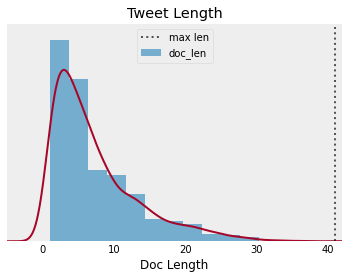

In [0]:
label_names = ['positive', 'neutral','negative']

train['doc_len'] = train['text'].apply(lambda words: len(words.split(' ')))

max_seq_len = np.max(train['doc_len'])

fig, ax = plt.subplots(figsize=(6,4))

train['doc_len'].plot(kind='hist',
                      density=True,
                      alpha=0.65,
                      bins=15)

train['doc_len'].plot(kind='kde', label='')

ax.set_xlim(-5, 42)
ax.set_xlabel("Doc Length")
ax.set_ylim(0, 0.13)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Tweet Length")
ax.grid(False)
ax.axvline(x=max_seq_len, alpha=0.65, color='k', linestyle=':', label='max len')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.legend()
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                     test_size=0.2,
                                                     random_state=42)

In [0]:
train_pos_length = (len(X_train[y_train == -1]) / (len(X_train)*1.))*100
train_neu_length = (len(X_train[y_train == 0]) / (len(X_train)*1.))*100
train_neg_length = (len(X_train[y_train == 1]) / (len(X_train)*1.))*100

valid_pos_length = (len(X_valid[y_valid == -1]) / (len(X_valid)*1.))*100
valid_neu_length = (len(X_valid[y_valid == 0]) / (len(X_valid)*1.))*100
valid_neg_length = (len(X_valid[y_valid == 1]) / (len(X_valid)*1.))*100

In [0]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral, {3:.2f}% positive".format(len(X_train),
                                                                             train_neg_length,
                                                                             train_neu_length,
                                                                             train_pos_length))
print("Valid set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral, {3:.2f}% positive".format(len(X_valid),
                                                                             valid_neg_length,
                                                                             valid_neu_length,
                                                                             valid_pos_length))

Train set has total 2320 entries with 2.54% negative, 2.54% neutral, 2.54% positive
Valid set has total 580 entries with 5.86% negative, 5.86% neutral, 5.86% positive




---



### **[Part 6] Tokenizing Training Data**

In [0]:
raw_docs_train = X_train
raw_docs_valid = X_valid
raw_docs_test  = test['text'].tolist()


MAX_NB_WORDS = 100000
num_classes = len(label_names)

print('=============================')
print(' >> Tokenizing Input Data >> ')
print('=============================')

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      lower=True,
                      char_level=False)
tokenizer.fit_on_texts(raw_docs_train + raw_docs_test + raw_docs_valid)


word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_valid = tokenizer.texts_to_sequences(raw_docs_valid)
word_seq_test  = tokenizer.texts_to_sequences(raw_docs_test)

word_index = tokenizer.word_index

print('Dictionary Size: ', len(word_index))

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen = max_seq_len)
word_seq_valid = sequence.pad_sequences(word_seq_valid, maxlen = max_seq_len)
word_seq_test  = sequence.pad_sequences(word_seq_test, maxlen = max_seq_len)



 >> Tokenizing Input Data >> 
Dictionary Size:  7495




---



### **[Part 7] Hyperparameters**

In [0]:
batch_size = 256
num_epochs = 16

num_filters = 64
embed_dim   = 100
weight_decay = 1e-4



---



### **[Part 8] Embedding Matrix**

In [0]:
print('==================================')
print(' >> Preparing Embedding Matrix >> ')
print('==================================')

words_not_found = []

nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words+1, embed_dim))

for word, i in word_index.items():
  if i >= nb_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if (embedding_vector is not None) and len(embedding_vector) > 0:
    embedding_matrix[i] = embedding_vector
  else:
    words_not_found.append(word)

print('Number of Null Word Embeddings : %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("Sample Words Not Found         :", np.random.choice(words_not_found, 5))

 >> Preparing Embedding Matrix >> 
Number of Null Word Embeddings : 323
Sample Words Not Found         : ['wadauuww' 'pemirsahh' 'kopet' 'ngentot' 'rspon']




---



### **[Part 9] Convert into Categorical Data**

In [0]:
target = []

for i in y_train:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

y_train = target

train_labels = to_categorical(y_train)

In [0]:
target = []

for i in y_valid:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

y_valid = target

valid_labels = to_categorical(y_valid)

In [0]:
target = []

for i in test['label']:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

test['new_label'] = target

test_labels = to_categorical(test['new_label'])


---



### **[Part 10] Early Stopping for Avoid Overfitting Model**

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01,
                               patience=3,
                               verbose=1)

callbacks_list = [early_stopping]


---



### **[Part 11] Conv. Neural Network Training**

In [0]:
print('=============================')
print('    >>> Training CNN >>>     ')
print('=============================')

model = Sequential(name='Final Model')
model.add(Embedding(nb_words+1, embed_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_len,
                    trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='softmax'))

adam = optimizers.Adam(lr = 0.01,
                      beta_1 = 0.9,
                      beta_2 = 0.999,
                      epsilon=1e-08,
                      decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

    >>> Training CNN >>>     
Model: "Final Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           749600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 41, 64)            44864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 64)            256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Ba

In [0]:
hist = model.fit(word_seq_train,
                 train_labels,
                 batch_size = batch_size,
                 epochs = num_epochs,
                 validation_data=(word_seq_valid, valid_labels),
                 callbacks = callbacks_list,
                 shuffle=True,
                 verbose=2)

ValueError: ignored


---



### **[Part 12] Loss and Accuracy Visualization**

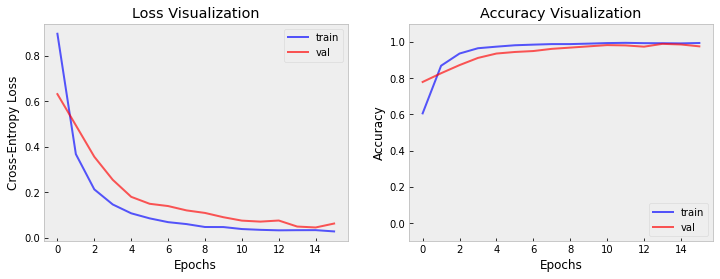

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()



---



### **[Part 13] Save Model**

In [0]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved tokenizer model to disk")

Saved tokenizer model to disk


In [0]:
!cp model.h5 '/content/drive/My Drive/Tugas_Akhir/model/'
!cp tokenizer.pickle '/content/drive/My Drive/Tugas_Akhir/model/'

print("Uploaded model to Google Drive")

Uploaded model to Google Drive



---



### **[Part 14] Prediction Output**

In [2]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/Tugas_Akhir/model/model.h5')

Using TensorFlow backend.


In [0]:
test  = pd.read_excel('/content/drive/My Drive/Tugas_Akhir/dataset/test_label.xlsx', index_col=0)

In [0]:
import pickle

# loading
with open('/content/drive/My Drive/Tugas_Akhir/model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
raw_docs_test  = test['text'].tolist()

word_seq_test  = tokenizer.texts_to_sequences(raw_docs_test)

word_index = tokenizer.word_index

print('Dictionary Size: ', len(word_index))

word_seq_test  = sequence.pad_sequences(word_seq_test, maxlen = 41)

Dictionary Size:  7495


In [0]:
target = []

for i in test['label']:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

test['new_label'] = target

test_labels = to_categorical(test['new_label'])

In [0]:
y_test = test['new_label']

In [0]:
y_pred = model.predict(word_seq_test).round()

In [0]:
pred_df = pd.DataFrame(data=y_pred)

In [0]:
y_pred = pred_df.values.argmax(1)

In [0]:
predict            = pd.DataFrame(columns=['text'] + ['label'] + ['predict'])
predict['text']    = test['text']
predict['label']   = y_test
predict['predict'] = y_pred


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [23]:
cm = confusion_matrix(y_test, y_pred)

print(cm)
print('Accuracy ' +str(accuracy_score(y_test, y_pred)))

[[190  13  21]
 [ 23 208   9]
 [ 26  37 155]]
Accuracy 0.8108504398826979


In [0]:
from google.colab import files

predict.to_excel('predict.xlsx')
files.download('predict.xlsx')